# Custom Models and Training with TensorFlow

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.4 is required in this notebook
# Earlier 2.x versions will mostly work the same, but with a few bugs
import tensorflow as tf
from tensorflow import keras
from packaging.version import Version
assert Version(tf.__version__) >= Version("2.4")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

2025-08-19 14:18:19.465706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755577099.480783  703159 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755577099.485774  703159 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Jupyter - if you want to always print the last expression or assignment\n
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

In [3]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])  # 2x3 matrix

I0000 00:00:1755577101.386505  703159 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14316 MB memory:  -> device: 0, name: Quadro RTX 5000 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [4]:
tf.constant(42)  # scalar

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [5]:
t.shape

TensorShape([2, 3])

In [6]:
t.dtype

tf.float32

In [7]:
t[:, 1:]

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[2., 3.],
       [5., 6.]], dtype=float32)>

In [8]:
t[..., 1, tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

In [9]:
t + 10

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[11., 12., 13.],
       [14., 15., 16.]], dtype=float32)>

In [10]:
tf.square(t)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)>

In [11]:
t @ tf.transpose(t)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

## Tensor and Numpy

In [12]:
a = np.array([2., 4., 5.])

array([2., 4., 5.])

In [13]:
tf.constant(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([2., 4., 5.])>

In [14]:
t.numpy()  # or np.array(t)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [15]:
tf.square(a)

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([ 4., 16., 25.])>

In [16]:
np.square(t)

array([[ 1.,  4.,  9.],
       [16., 25., 36.]], dtype=float32)

In [17]:
#tf.constant(2.) + tf.constant(40)  # type conversions are not done automatically to avoid degrading performances

In [18]:
#tf.constant(2.) + tf.constant(40., dtype=tf.float64)  # even adding float32 and float64 is not allowed

In [19]:
t2 = tf.constant(40., dtype=tf.float64)

<tf.Tensor: shape=(), dtype=float64, numpy=40.0>

In [20]:
tf.constant(2.) + tf.cast(t2, tf.float32)  # so we use casting

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

## Variables

In [21]:
v = tf.Variable(t)

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [22]:
v.assign(2*v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [23]:
v[0, 1].assign(42)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [24]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., 42.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [25]:
v.scatter_nd_update(indices=[[0, 0], [1, 2]], updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  42.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

## Custom Loss Functions

In [26]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

array([[-1.15780104, -0.28673138, -0.49550877, ...,  0.38899735,
         0.19374821,  0.2870474 ],
       [-0.7125531 ,  0.10880952, -0.16332973, ..., -0.11818174,
        -0.23725261,  0.06215231],
       [-0.2156101 ,  1.8491895 , -0.57982788, ..., -0.67694905,
         1.00890193, -1.4271529 ],
       ...,
       [-0.90351581,  0.66256679, -0.8562583 , ...,  0.68837768,
        -0.76194926,  0.66187253],
       [ 1.56873373, -1.78978682,  0.75535703, ..., -0.18226735,
         1.34152212, -0.73747465],
       [ 1.43527981,  0.58345861,  0.10928062, ..., -0.17819366,
        -0.82285155,  0.59190517]], shape=(5160, 8))

In [27]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

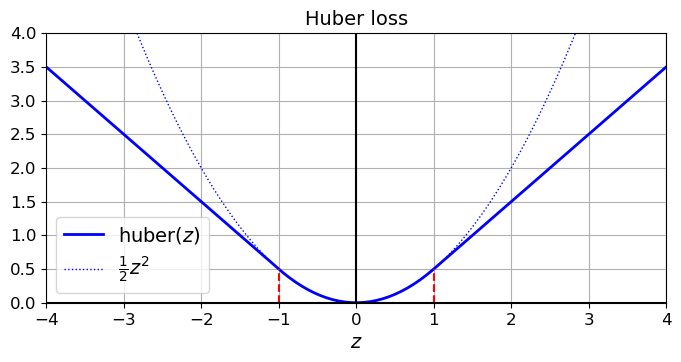

In [28]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z**2 / 2, "b:", linewidth=1, label=r"$\frac{1}{2}z^2$")
plt.plot([-1, -1], [0, huber_fn(0., -1.)], "r--")
plt.plot([1, 1], [0, huber_fn(0., 1.)], "r--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [29]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

/home/ngu145/miniconda/envs/tf/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=sequential, built=True>

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │           270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 301 (1.18 KB)

 Trainable params: 301 (1.18 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(loss=huber_fn, optimizer="nadam")
model.fit(X_train, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2


I0000 00:00:1755577105.405548  704465 service.cc:148] XLA service 0x78e88c007650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755577105.405567  704465 service.cc:156]   StreamExecutor device (0): Quadro RTX 5000 with Max-Q Design, Compute Capability 7.5
2025-08-19 14:18:25.430958: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755577105.465856  704465 cuda_dnn.cc:529] Loaded cuDNN version 91100


173/363 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 138.0595

I0000 00:00:1755577106.186414  704465 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 25.3140 - val_loss: 1.6596
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2144 - val_loss: 1.5876


In [32]:
model.save("my_model_with_a_custom_loss.keras")

In [33]:
model = keras.models.load_model('my_model_with_a_custom_loss.keras', custom_objects={'huber_fn': huber_fn})

<Sequential name=sequential, built=True>

In [34]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss = threshold* tf.abs(error) - threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    return huber_fn

In [35]:
model.compile(loss=create_huber(2.0), optimizer='nadam')

In [36]:
model.save('my_model_with_a_custom_loss_threshold.keras')

In [37]:
model = keras.models.load_model('my_model_with_a_custom_loss_threshold.keras',
                                custom_objects={'huber_fn': create_huber(2.0)})

/home/ngu145/miniconda/envs/tf/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 11 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


<Sequential name=sequential, built=True>

In [38]:
class HuberLoss(keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold* tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, 'threshold': self.threshold}

In [39]:
model.compile(loss=HuberLoss(2.), optimizer='nadam')
model.fit(X_train, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2610 - val_loss: 2.3721
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9887 - val_loss: 2.3154


In [40]:
model.save('my_model_with_a_custom_loss_class.keras')

In [41]:
model = keras.models.load_model('my_model_with_a_custom_loss_class.keras',
                                custom_objects={'HuberLoss': HuberLoss})

<Sequential name=sequential, built=True>

In [42]:
model.fit(X_train, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9154 - val_loss: 2.2490
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8776 - val_loss: 2.2188


In [43]:
model.loss.threshold

2.0

## Custom Activation Functions, Initializers, Regularizers, and Constraints

In [44]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [45]:
def my_softplus(z):  # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)

In [46]:
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

In [48]:
def my_positive_weights(weights):  # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0, tf.zeros_like(weights), weights)

In [56]:
class MyL1Regularizer(keras.regularizers.Regularizer):
    def __init__(self, strength=1.0):
        self.strength = strength

    def __call__(self, weights):
            return self.strength * tf.reduce_sum(tf.abs(0.01 + weights))

In [57]:
my_l1_regularizer = MyL1Regularizer(strength=1.0)

In [64]:
class MyPositiveWeights(keras.constraints.Constraint):
    def __init__(self):
        super().__init__()

    def __call__(self, weights):
        return tf.where(weights < 0, tf.zeros_like(weights), weights)

In [65]:
my_positive_weights = MyPositiveWeights()

In [66]:
layer = keras.layers.Dense(30, activation=my_softplus,
                           kernel_initializer=my_glorot_initializer,
                           kernel_regularizer=my_l1_regularizer,
                           kernel_constraint=my_positive_weights)

<Dense name=dense_2, built=False>

In [67]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [68]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(1, activation=my_softplus,
                       kernel_regularizer=my_l1_regularizer,
                       kernel_constraint=my_positive_weights,
                       kernel_initializer=my_glorot_initializer),
])

<Sequential name=sequential, built=False>

In [69]:
model.compile(loss="mse", optimizer="nadam", metrics=["mae"])

In [70]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.2639 - mae: 1.2225 - val_loss: 2.9577 - val_mae: 0.9771
Epoch 2/2
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.5050 - mae: 0.8111 - val_loss: 2.0282 - val_mae: 0.6417
